In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error, root_mean_squared_error
import geobleu
print(dir(geobleu))

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
SMALL_DATASET = False
ROUTE = "/content/drive/MyDrive/Data/cityA_groundtruthdata_small.csv" if SMALL_DATASET else "/content/drive/MyDrive/Data/cityA_groundtruthdata_first_3000_users.csv"

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'calc_dtw', 'calc_dtw_orig', 'calc_dtw_single', 'calc_geobleu', 'calc_geobleu_orig', 'calc_geobleu_single', 'seq_eval']


In [2]:
def fill_missing_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rellena los datos faltantes de usuario, día y timeslot.
    Asigna -1 a las coordenadas faltantes (x, y).

    Args:
        df (pd.DataFrame): DataFrame original con columnas ['uid', 'd', 't', 'x', 'y'].

    Returns:
        pd.DataFrame: DataFrame con datos completos (incluidos los faltantes).
    """
    # Determinar los rangos de uid, días y timeslots
    uids = df["uid"].unique()
    days = np.arange(df["d"].min(), df["d"].max() + 1)
    timeslots = np.arange(48)  # 48 time slots por día

    # Crear una base completa con todas las combinaciones de uid, día y timeslot
    complete_index = pd.MultiIndex.from_product(
        [uids, days, timeslots], names=["uid", "d", "t"]
    )
    complete_df = pd.DataFrame(index=complete_index).reset_index()

    # Combinar con los datos originales
    df = pd.merge(complete_df, df, on=["uid", "d", "t"], how="left")

    # Rellenar valores faltantes: asignar -1 a las coordenadas
    df["x"] = df["x"].fillna(-1)
    df["y"] = df["y"].fillna(-1)

    return df


def split_data(df: pd.DataFrame) -> tuple:
    """
    Divide los datos en entrenamiento, validación y prueba, asegurando 15 días adicionales
    para las secuencias de validación y prueba.
    """

    # Entrenamiento: datos antes del día 44
    train = df[df["d"] < 44]

    # Validación: incluye días desde el 37 (44 - 7) para construir las secuencias
    val = df[(df["d"] >= 37) & (df["d"] < 59)]

    # Prueba: incluye días desde el 52 (59 - 7) para construir las secuencias
    test = df[df["d"] >= 52]

    return train.copy(), val.copy(), test.copy()


def create_sequences(
    data: pd.DataFrame,
    columns,
    input_days=7,
    predict_days=7,
    times_per_day=48,
    for_day=True,
):
    """
    Crea las secuencias deslizantes para entrada y predicción.

    Args:
        data (pd.DataFrame): Datos completos con columnas ['x', 'y', 't', 'd'].
        input_days (int): Número de días de entrada.
        predict_days (int): Número de días a predecir.
        times_per_day (int): Cantidad de time slots por día.

    Returns:
        list of tuples: Lista de (input_seq, target_seq).
    """
    input_steps = input_days * times_per_day
    predict_steps = predict_days * times_per_day
    sequences = []

    # Convertir a numpy para mayor eficiencia
    data_array = data[columns].values

    # Crear la máscara (1 si no es 0, 0 si es 0)
    mask = (data_array != 0).astype(int)

    # Generar las ventanas deslizantes

    for idx in range(
        0, len(data) - input_steps - predict_steps, times_per_day if for_day else 1
    ):  # ventanas por dias
        # Secuencia de entrada (15 días)
        input_seq = data_array[idx : idx + input_steps]
        mask_seq = mask[idx : idx + input_steps]

        # Secuencia de salida (7 días)
        target_seq = data_array[
            idx + input_steps : idx + input_steps + predict_steps, :2
        ]  # Solo x, y
        mask_target = mask[idx + input_steps : idx + input_steps + predict_steps, :2]

        sequences.append((input_seq, target_seq, mask_seq, mask_target))

    return sequences


def get_scaler(df: pd.DataFrame, columns: list):
    """
    Ajusta un MinMaxScaler a las columnas especificadas del DataFrame y devuelve el scaler.

    Args:
        df (pd.DataFrame): DataFrame con los datos originales.
        columns (list): Lista de nombres de columnas a normalizar.

    Returns:
        scaler: Instancia ajustada de MinMaxScaler.
    """
    # Crear un scaler
    scaler = MinMaxScaler()

    # Ajustar el scaler a las columnas especificadas
    scaler.fit(df[columns])
    return scaler


def normalize_dataset(df: pd.DataFrame, scaler: MinMaxScaler, columns: list):
    """
    Normaliza las columnas especificadas de un DataFrame utilizando un MinMaxScaler ya ajustado.

    Args:
        df (pd.DataFrame): DataFrame con los datos originales.
        scaler (MinMaxScaler): Scaler ajustado con los datos de entrenamiento.
        columns (list): Lista de nombres de columnas a normalizar.

    Returns:
        pd.DataFrame: DataFrame normalizado
    """
    # Transformar las columnas especificadas con el scaler ajustado
    df[columns] = scaler.transform(df[columns])
    return df


def inverse_transform_predictions(

    predictions, scaler: MinMaxScaler, columns_to_desnormalize
):
    """
    Desnormaliza las predicciones del modelo usando el scaler ajustado.

    Args:
        predictions (torch.Tensor or np.ndarray): Predicciones normalizadas con forma (batch_size, sequence_length, num_features).
        scaler (MinMaxScaler): Scaler ajustado con los datos de entrada.
        columns_to_desnormalize (list): Índices de las columnas a desnormalizar (por ejemplo, [0, 1] para x, y).

    Returns:
        np.ndarray: Predicciones desnormalizadas con la misma forma que las predicciones originales.
    """
    # Si es un tensor de PyTorch, conviértelo a un numpy array
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    batch_size, sequence_length, num_features = predictions.shape

    # Crear un array desnormalizado con la misma forma que las predicciones
    desnormalized = np.zeros_like(predictions)

    # Desnormalizar cada elemento del batch
    for i in range(batch_size):
        # Extraer la predicción del batch actual (sequence_length, num_features)
        single_prediction = predictions[i]

        # Crear una matriz con el mismo número de columnas que el scaler original
        full_array = np.zeros((sequence_length, scaler.n_features_in_))

        # Insertar las predicciones en las columnas correspondientes
        full_array[:, columns_to_desnormalize] = single_prediction

        # Aplicar la transformación inversa
        full_array = scaler.inverse_transform(full_array)

        # Extraer las columnas desnormalizadas correspondientes
        desnormalized[i] = full_array[:, columns_to_desnormalize]

    return desnormalized

In [3]:
class GRU_Dataset(Dataset):
    def __init__(self, sequences):
        """
        Dataset que maneja las secuencias generadas de entrada, salida y máscara.

        Args:
            sequences (list of tuples): Lista de (input_seq, target_seq, mask_seq, mask_target_seq).
        """
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        input_seq, target_seq, mask_seq, mask_target_seq = self.sequences[idx]
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        target_seq = torch.tensor(target_seq, dtype=torch.float32)
        mask_seq = torch.tensor(mask_seq, dtype=torch.float32)
        mask_target_seq = torch.tensor(mask_target_seq, dtype=torch.float32)
        return input_seq, target_seq, mask_seq, mask_target_seq

In [4]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        """
        Modelo GRU para predicción de series temporales.

        Args:
            input_size (int): Número de características de entrada (e.g., 3: x, y, t).
            hidden_size (int): Dimensión del estado oculto de la GRU.
            output_size (int): Número de características de salida (e.g., 2: x, y).
            num_layers (int): Número de capas GRU.
            dropout (float): Dropout para regularización.
        """
        super(GRU_Model, self).__init__()
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass del modelo.

        Args:
            x (torch.Tensor): Tensor de entrada con forma (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: Predicciones con forma (batch_size, prediction_length, output_size).
        """
        # x -> (batch_size, sequence_length, input_size)
        out, _ = self.gru(x)  # out -> (batch_size, sequence_length, hidden_size)
        out = self.fc(out)  # out -> (batch_size, sequence_length, output_size)
        return out

In [5]:
def train_gru_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    learning_rate: float,
    device: torch.device,
):
    """
    Entrena el modelo GRU con un ciclo de entrenamiento y validación.

    Args:
        model (nn.Module): Modelo GRU.
        train_loader (DataLoader): DataLoader para entrenamiento.
        val_loader (DataLoader): DataLoader para validación.
        epochs (int): Número de épocas.
        learning_rate (float): Tasa de aprendizaje.
        device (torch.device): Dispositivo para computación (CPU/GPU).

    Returns:
        dict: Diccionario con:
            - 'best_model': Modelo con el mejor desempeño en validación.
            - 'train_losses': Lista de pérdidas de entrenamiento por época.
            - 'val_losses': Lista de pérdidas de validación por época.
            - 'best_epoch': Época con la menor pérdida de validación.
    """
    # Mover modelo a dispositivo
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss(
        reduction="none"
    )  # Usamos reducción personalizada para manejar máscaras

    best_model_weights = None
    best_val_loss = float("inf")  # Mejor pérdida de validación
    best_epoch = -1

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Modo de entrenamiento
        model.train()
        train_loss = 0.0

        for inputs, targets, masks_inputs, masks_targets in train_loader:
            # Mover datos a dispositivo
            inputs, targets, masks_targets = (
                inputs.to(device),
                targets.to(device),
                masks_targets.to(device),
            )

            # Forward
            optimizer.zero_grad()
            outputs = model(inputs)
            if torch.isnan(inputs).any() or torch.isnan(targets).any() or torch.isnan(masks_targets).any():
              print("⚠️ Warning: Se encontraron NaN en los datos de entrada o las etiquetas")

            # Aplicar la máscara a la pérdida
            loss = criterion(outputs, targets)
            mask_sum = masks_targets.sum()
            if mask_sum == 0:
              print("⚠️ Warning: No se encontraron valores válidos en la máscara")
              loss = loss.mean()  # Si no hay valores válidos, tomar el promedio normal
            else:
                loss = (loss * masks_targets).sum() / mask_sum  # Normalización correcta
            # loss = (loss * masks_targets).sum() / masks_targets.sum()  # Pérdida ponderada por la máscara

            # Backpropagation
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, masks_inputs, masks_targets in val_loader:
                inputs, targets, masks_targets = (
                    inputs.to(device),
                    targets.to(device),
                    masks_targets.to(device),
                )
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss = (loss * masks_targets).sum() / masks_targets.sum()
                val_loss += loss.item()

        # Promedio de las pérdidas
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Guardar los pesos del mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            best_model_weights = copy.deepcopy(model.state_dict())  # Guardar los pesos

    print(
        f"\nEl mejor modelo se obtuvo en la época {best_epoch} con una pérdida de validación de {best_val_loss:.4f}."
    )

    # Cargar los mejores pesos en el modelo
    model.load_state_dict(best_model_weights)

    return {
        "best_model": model,  # Devuelve el modelo con los mejores pesos
        "train_losses": train_losses,
        "val_losses": val_losses,
        "best_epoch": best_epoch,
    }


def evaluate_model(
    model,
    data_loader,
    scaler,
    columns_to_desnormalize,
    device,
    dataset_name="Validación",
):
    """
    Evalúa el desempeño del modelo en un conjunto de datos (validación o prueba).

    Args:
        model (nn.Module): Modelo GRU entrenado.
        data_loader (DataLoader): DataLoader para el conjunto a evaluar.
        scaler (MinMaxScaler): Scaler ajustado con los datos de entrenamiento.
        columns_to_desnormalize (list): Columnas a desnormalizar.
        device (torch.device): Dispositivo de computación (CPU/GPU).
        dataset_name (str): Nombre del conjunto de datos (para identificar la evaluación).

    Returns:
        dict: Métricas de evaluación (MAE, RMSE, pérdida promedio).
    """
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    criterion = nn.MSELoss(
        reduction="none"
    )  # Usamos reducción 'none' para manejar máscaras

    with torch.no_grad():
        for inputs, targets, masks_inputs, masks_targets in data_loader:
            # Mover a dispositivo
            inputs, targets, masks_targets = (
                inputs.to(device),
                targets.to(device),
                masks_targets.to(device),
            )

            # Predicciones del modelo
            outputs = model(inputs)

            # Calcular la pérdida con la máscara
            loss = criterion(outputs, targets)
            loss = (loss * masks_targets).sum() / masks_targets.sum()
            total_loss += loss.item()

            # Desnormalizar las predicciones y valores reales
            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs_desnormalized = inverse_transform_predictions(
                outputs, scaler, columns_to_desnormalize
            )
            targets_desnormalized = inverse_transform_predictions(
                targets, scaler, columns_to_desnormalize
            )

            # Convertir la máscara a NumPy
            masks_targets_numpy = masks_targets.cpu().numpy()

            # Aplicar la máscara para poner NaN en posiciones no válidas
            outputs_desnormalized[masks_targets_numpy == 0] = np.nan
            targets_desnormalized[masks_targets_numpy == 0] = np.nan

            # Almacenar para métricas globales
            all_predictions.append(outputs_desnormalized)
            all_targets.append(targets_desnormalized)

    # Concatenar todas las predicciones y objetivos (3D -> 2D)
    all_predictions = np.concatenate(all_predictions, axis=0).reshape(-1, 2)  # Aplanar
    all_targets = np.concatenate(all_targets, axis=0).reshape(-1, 2)  # Aplanar

    # Remover NaN introducidos por la máscara
    valid_indices = ~np.isnan(all_predictions[:, 0])
    all_predictions = all_predictions[valid_indices]
    all_targets = all_targets[valid_indices]

    # Calcular métricas usando NumPy o scikit-learn
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = root_mean_squared_error(all_targets, all_predictions)
    avg_loss = total_loss / len(data_loader)

    print(f"Resultados en {dataset_name}:")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - Loss: {avg_loss:.4f}")

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Loss": avg_loss,
        "Predictions": all_predictions,
        "Targets": all_targets,
    }

In [6]:
def evaluate_metrics_sequence(
    data, model, scaler,columns, device
):
    """
    Evalúa las métricas definidas en base a las predicciones generadas por el modelo para una sola secuencia.

    Args:
        data (pd.DataFrame): Dataset que contiene las columnas necesarias.
        model (nn.Module): Modelo GRU entrenado.
        scaler (MinMaxScaler): Scaler ajustado para normalización/desnormalización.
        metrics_instances (list): Lista de instancias de métricas (e.g., LPPMetric, MAEMetric, etc.).
        columns (list): Columnas necesarias para el modelo (e.g., ['x', 'y', 't', 'd']).
        device (torch.device): Dispositivo donde se ejecutará el modelo (CPU o GPU).

    Returns:
        dict: Resultados de las métricas calculadas.
    """
    model.to(device)

    model.eval()

    # Definir parámetros
    times_per_day = 48
    input_days = 7  # Días de entrada
    predict_days = 7  # Días de predicción

    # Crear la secuencia usando el primer día del dataset como referencia
    sequences = create_sequences(
        data,
        columns=columns,
        input_days=input_days,
        predict_days=predict_days,
        times_per_day=times_per_day,
        for_day=True,
    )

    # Solo necesitamos una secuencia
    input_seq, target_seq, mask_seq, mask_target = sequences[0]

    # Convertir a tensores
    input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)

    # Generar predicciones
    with torch.no_grad():
        predictions = model(input_tensor).cpu().numpy()

    # Desnormalizar las predicciones
    predictions_desnormalized = inverse_transform_predictions(
        predictions, scaler, [0, 1]  # Desnormalizamos las columnas `x` e `y`
    )

    # Reconstruir (d, t, x, y) para predicciones y targets, considerando solo los datos válidos por la máscara
    generated_sequences = []
    reference_sequences = []

    current_day = int(data["d"].iloc[0])  # Primer día del dataset
    current_timeslot = 0

    n_columns = scaler.n_features_in_
    for step_idx, (x_pred, y_pred) in enumerate(
        predictions_desnormalized[0]
    ):  # Batch único
        if mask_target[step_idx].sum() > 0:  # Considerar solo si la máscara lo permite
            day_offset = current_timeslot // times_per_day
            d = current_day + day_offset
            t = current_timeslot % times_per_day

            generated_sequences.append((d, t, x_pred, y_pred))

            # Target correspondiente (desnormalizar targets)
            x_true, y_true = target_seq[step_idx]
            # Creas un arreglo de ceros con el tamaño total de columnas
            features_array = np.zeros(n_columns)
            features_array[0] = x_true
            features_array[1] = y_true
            target_desnormalized = scaler.inverse_transform(
                [features_array]
            )  # Columna extra para mantener el tamaño
            x_true_desnormalized, y_true_desnormalized = target_desnormalized[0][:2]
            reference_sequences.append(
                (d, t, x_true_desnormalized, y_true_desnormalized)
            )

        current_timeslot += 1

    return generated_sequences, reference_sequences

In [7]:
from abc import ABC, abstractmethod
import geobleu
import numpy as np


class Metric(ABC):
    """
    Clase base abstracta para diferentes métricas.
    """

    @abstractmethod
    def calculate(self, predictions, validation):
        """
        Calcula el puntaje de la métrica basada en las predicciones y los datos de validación.

        Args:
            predictions: Los datos predichos.
            validation: Los datos de validación.

        Returns:
            El puntaje calculado.
        """
        pass


class LPPMetric(Metric):
    """
    Métrica para calcular la Precisión de Predicción de Ubicación (LPP).
    """

    def calculate(self, predictions, validation):
        return calculate_lpp(validation, predictions)


class MAEMetric(Metric):
    """
    Métrica para calcular el Error Medio Absoluto (MAE).
    """

    def calculate(self, predictions_per_user, validation_per_user):
        return calculate_error_metrics(predictions_per_user, validation_per_user)["MAE"]


class GeoBLEUMetric(Metric):
    """
    Métrica para calcular el puntaje GeoBLEU.
    """

    def calculate(self, predictions_per_user, validation_per_user):
        return calculate_geobleu_for_quadrant(predictions_per_user, validation_per_user)


class DTWMetric(Metric):
    """
    Métrica para calcular el puntaje de Dynamic Time Warping (DTW).
    """

    def calculate(self, predictions_per_user, validation_per_user):
        return calculate_dtw_for_quadrant(predictions_per_user, validation_per_user)


def calculate_lpp(predictions_per_user, validation_per_user, tolerance=4.0):
    """
    Calcula la Precisión de Predicción de Ubicación (LPP), ignorando los valores NaN,
    y permitiendo un margen de error definido por un umbral.

    Args:
        predictions_per_user (list of list of tuples): Lista de trayectorias generadas por cada usuario.
        validation_per_user (list of list of tuples): Lista de trayectorias reales por cada usuario.
        tolerance (float): Margen de error en unidades de distancia para considerar una predicción correcta.

    Returns:
        float: La precisión de ubicación como porcentaje de coincidencias dentro del margen.
    """
    correct_predictions = 0
    total_predictions = 0

    for predicted_traj, actual_traj in zip(predictions_per_user, validation_per_user):
        for predicted_point, actual_point in zip(predicted_traj, actual_traj):
            # Asegurar que las coordenadas reales no sean NaN
            if not any(np.isnan(coord) for coord in actual_point[2:]):
                # Calcular distancia euclidiana entre puntos predichos y reales
                distance = np.sqrt(
                    (predicted_point[2] - actual_point[2]) ** 2
                    + (predicted_point[3] - actual_point[3]) ** 2
                )
                # Contar como correcta si la distancia está dentro del margen de tolerancia
                if distance <= tolerance:
                    correct_predictions += 1
                total_predictions += 1

    # Calcular el porcentaje de precisión
    lpp = (
        (correct_predictions / total_predictions) * 100
        if total_predictions > 0
        else 0.0
    )
    return lpp


def calculate_error_metrics(predictions_per_user, validation_per_user):
    """
    Calcula métricas de error entre trayectorias predichas y reales:
    - Error Medio Absoluto (MAE)
    - Error Máximo
    - Distribución de Errores

    Args:
        predictions_per_user (list of list of tuples): Trayectorias predichas [(d, t, x, y)].
        validation_per_user (list of list of tuples): Trayectorias reales [(d, t, x, y)].

    Returns:
        dict: Métricas calculadas.
    """
    errors = []

    for predicted_traj, actual_traj in zip(predictions_per_user, validation_per_user):
        for predicted_point, actual_point in zip(predicted_traj, actual_traj):
            # Ignorar puntos donde las coordenadas reales sean NaN
            if not any(np.isnan(coord) for coord in actual_point[2:]):
                # Calcular distancia euclidiana
                distance = np.sqrt(
                    (predicted_point[2] - actual_point[2]) ** 2
                    + (predicted_point[3] - actual_point[3]) ** 2
                )
                errors.append(distance)

    # Calcular métricas
    mae = np.mean(errors) if errors else 0.0
    max_error = np.max(errors) if errors else 0.0

    # Retornar resultados
    return {"MAE": mae, "Max Error": max_error, "Errors": errors}


def calculate_geobleu_for_quadrant(predictions_per_user, validation_per_user):
    """
    Calcula el puntaje promedio de GeoBLEU para cada usuario comparando las trayectorias generadas y de referencia.

    Args:
        predictions_per_user (list of list of tuples): Lista de trayectorias generadas por cada usuario.
        validation_per_user (list of list of tuples): Lista de trayectorias de referencia por cada usuario.

    Returns:
        float: El puntaje promedio de GeoBLEU para todos los usuarios comparados.
    """
    total_score = 0
    valid_users = 0
    for predictions, validation in zip(predictions_per_user, validation_per_user):
        if predictions and validation:  # Aseguramos que haya datos comparables
            score = geobleu.calc_geobleu(predictions, validation, processes=3)
            total_score += score
            valid_users += 1
    return total_score / valid_users if valid_users else 0


def calculate_dtw_for_quadrant(predictions_per_user, validation_per_user):
    """
    Calcula el puntaje promedio de DTW para cada usuario comparando las trayectorias generadas y de referencia.

    Args:
        predictions_per_user (list of list of tuples): Lista de trayectorias generadas por cada usuario.
        validation_per_user (list of list of tuples): Lista de trayectorias de referencia por cada usuario.

    Returns:
        float: El puntaje promedio de DTW para todos los usuarios comparados.
    """
    total_score = 0
    valid_users = 0
    for predictions, validation in zip(predictions_per_user, validation_per_user):
        if predictions and validation:  # Aseguramos que haya datos comparables
            score = geobleu.calc_dtw(predictions, validation)
            total_score += score
            valid_users += 1
    return total_score / valid_users if valid_users else 0


In [8]:
df = pd.read_csv(ROUTE)

In [9]:
df_fill = fill_missing_data(df)

In [10]:
COLUMNS = ["x", "y", "t"]

# Dividir los datos
train_data, val_data, test_data = split_data(df_fill)

# Ajustar el scaler a los datos de entrenamiento
scaler = get_scaler(train_data, COLUMNS)

# Normalizar los datos solamnete con l scaler del train
train_data = normalize_dataset(train_data, scaler, COLUMNS)
val_data = normalize_dataset(val_data, scaler, COLUMNS)
test_data = normalize_dataset(test_data, scaler, COLUMNS)

# Crear las secuencias para cada conjunto
train_sequences = create_sequences(train_data, COLUMNS)
val_sequences = create_sequences(val_data, COLUMNS)
test_sequences = create_sequences(test_data, COLUMNS)

# Crear datasets
train_dataset = GRU_Dataset(train_sequences)
val_dataset = GRU_Dataset(val_sequences)
test_dataset = GRU_Dataset(test_sequences)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Hiperparámetros
input_size = 3  # Número de características de entrada: x, y, t
hidden_size = 128  # Tamaño del estado oculto de la GRU
output_size = 2  # Predicción de x, y
num_layers = 3  # Capas GRU
dropout = 0.2  # Dropout para regularización


model = GRU_Model(input_size, hidden_size, output_size, num_layers, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/30, Train Loss: 0.0284, Val Loss: 0.0346
Epoch 2/30, Train Loss: 0.0230, Val Loss: 0.0335
Epoch 3/30, Train Loss: 0.0219, Val Loss: 0.0323
Epoch 4/30, Train Loss: 0.0205, Val Loss: 0.0309
Epoch 5/30, Train Loss: 0.0201, Val Loss: 0.0305
Epoch 6/30, Train Loss: 0.0198, Val Loss: 0.0301
Epoch 7/30, Train Loss: 0.0197, Val Loss: 0.0300
Epoch 8/30, Train Loss: 0.0195, Val Loss: 0.0298
Epoch 9/30, Train Loss: 0.0194, Val Loss: 0.0297
Epoch 10/30, Train Loss: 0.0193, Val Loss: 0.0298
Epoch 11/30, Train Loss: 0.0192, Val Loss: 0.0298
Epoch 12/30, Train Loss: 0.0191, Val Loss: 0.0297
Epoch 13/30, Train Loss: 0.0190, Val Loss: 0.0297
Epoch 14/30, Train Loss: 0.0189, Val Loss: 0.0297
Epoch 15/30, Train Loss: 0.0188, Val Loss: 0.0296
Epoch 16/30, Train Loss: 0.0187, Val Loss: 0.0297
Epoch 17/30, Train Loss: 0.0187, Val Loss: 0.0298
Epoch 18/30, Train Loss: 0.0186, Val Loss: 0.0297
Epoch 19/30, Train Loss: 0.0185, Val Loss: 0.0299
Epoch 20/30, Train Loss: 0.0185, Val Loss: 0.0300
Epoch 21/

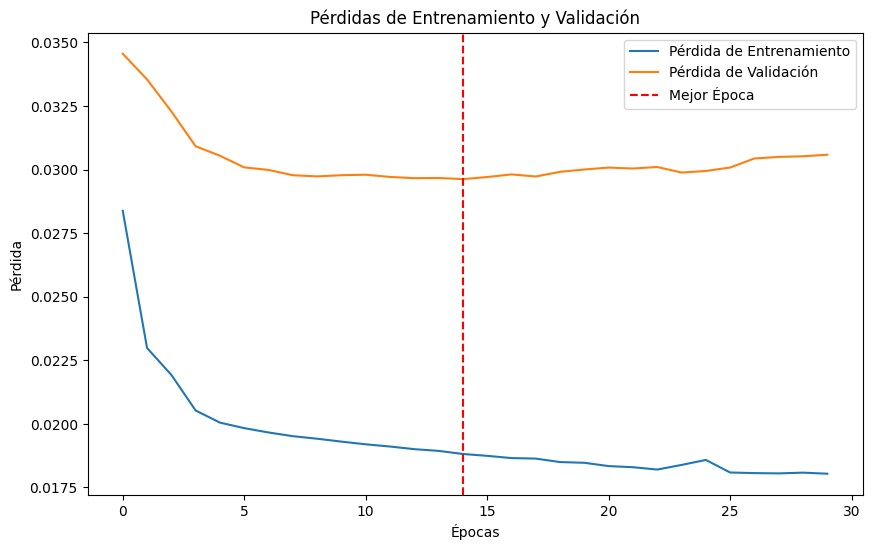

In [12]:
# Hiperparámetros
epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar el modelo
# Entrenar el modelo
results = train_gru_model(
    model, train_loader, val_loader, epochs=epochs, learning_rate=learning_rate, device=device
)

# Extraer los datos del entrenamiento
train_losses = results["train_losses"]
val_losses = results["val_losses"]
best_epoch = results["best_epoch"]
nodel = results["best_model"]

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Pérdida de Entrenamiento")
plt.plot(val_losses, label="Pérdida de Validación")
plt.axvline(best_epoch - 1, color="red", linestyle="--", label="Mejor Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdidas de Entrenamiento y Validación")
plt.legend()
plt.show()

In [13]:
# Evaluar en validación
val_metrics = evaluate_model(
    model, val_loader, scaler, [0, 1], device, dataset_name="Validación"
)

# Evaluar en prueba
test_metrics = evaluate_model(
    model, test_loader, scaler, [0, 1], device, dataset_name="Prueba"
)

Resultados en Validación:
  - MAE: 23.6133
  - RMSE: 34.3154
  - Loss: 0.0296
Resultados en Prueba:
  - MAE: 22.7424
  - RMSE: 33.2972
  - Loss: 0.0278


In [14]:
save_path = "./models/gru_model_x_y_t.pth"

In [15]:
torch.save(model.state_dict(),save_path)

In [16]:
model.load_state_dict(torch.load(save_path))

<ipython-input-16-ed547ae5db2b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


<All keys matched successfully>

In [17]:
# Instancias de métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    DTWMetric(),
    GeoBLEUMetric(),
]

# Evaluar las métricas a partir del día 60
generated_sequences, reference_sequences = evaluate_metrics_sequence(
    test_data,
    model,
    scaler,
    columns=COLUMNS,
    device=device,
)

# Calcular métricas
results = {}
for metric in metrics_instances:
    metric_name = type(metric).__name__
    results[metric_name] = metric.calculate([generated_sequences], [reference_sequences])

# Mostrar resultados
print(f"Métricas para {type(model).__name__} con {COLUMNS} :")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")

Métricas para GRU_Model con ['x', 'y', 't'] :
LPPMetric score: 1.2345679012345678
MAEMetric score: 33.45532280796783
DTWMetric score: 315.76513122326975
GeoBLEUMetric score: 0.0012770605122526869


In [19]:
del generated_sequences , reference_sequences
del train_data, val_data, test_data  # Liberar memoria
del train_sequences, val_sequences, test_sequences  # Liberar memoria
del train_dataset, val_dataset, test_dataset  # Liberar memoria
del train_loader, val_loader, test_loader  # Liberar memoria

In [20]:
def add_feature(df: pd.DataFrame, feature: str, function):
    """
    Agrega una característica al DataFrame.

    Args:
        df (pd.DataFrame): DataFrame original.
        feature (str): Nombre de la característica a agregar.
        function: Función para calcular la característica.

    Returns:
        pd.DataFrame: DataFrame con la nueva característica.
    """
    df = df.copy()
    df[feature] = function(df)
    return df


def add_day_of_week(df: pd.DataFrame) -> pd.Series:
    """
    Calcula el día de la semana a partir de la columna 'd'.

    Args:
        df (pd.DataFrame): DataFrame con la columna 'd'.

    Returns:
        pd.Series: Día de la semana correspondiente a cada día.
    """
    return df["d"] % 7

In [21]:
df_day_of_week = add_feature(df_fill, "day_of_week", add_day_of_week)

COLUMNS = ["x", "y", "t", "day_of_week"]

# Dividir los datos
train_data, val_data, test_data = split_data(df_day_of_week)

# Ajustar el scaler a los datos de entrenamiento
scaler = get_scaler(train_data, COLUMNS)

# Normalizar los datos solamnete con l scaler del train
train_data = normalize_dataset(train_data, scaler, COLUMNS)
val_data = normalize_dataset(val_data, scaler, COLUMNS)
test_data = normalize_dataset(test_data, scaler, COLUMNS)

# Crear las secuencias para cada conjunto
train_sequences = create_sequences(train_data, COLUMNS)
val_sequences = create_sequences(val_data, COLUMNS)
test_sequences = create_sequences(test_data, COLUMNS)

# Crear datasets
train_dataset = GRU_Dataset(train_sequences)
val_dataset = GRU_Dataset(val_sequences)
test_dataset = GRU_Dataset(test_sequences)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# Hiperparámetros
input_size = 4  # Número de características de entrada: x, y, t
hidden_size = 256  # Tamaño del estado oculto de la GRU
output_size = 2  # Predicción de x, y
num_layers = 5  # Capas GRU
dropout = 0.2  # Dropout para regularización


model = GRU_Model(input_size, hidden_size, output_size, num_layers, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/30, Train Loss: 0.0323, Val Loss: 0.0332
Epoch 2/30, Train Loss: 0.0244, Val Loss: 0.0333
Epoch 3/30, Train Loss: 0.0225, Val Loss: 0.0322
Epoch 4/30, Train Loss: 0.0216, Val Loss: 0.0316
Epoch 5/30, Train Loss: 0.0208, Val Loss: 0.0313
Epoch 6/30, Train Loss: 0.0205, Val Loss: 0.0312
Epoch 7/30, Train Loss: 0.0203, Val Loss: 0.0305
Epoch 8/30, Train Loss: 0.0198, Val Loss: 0.0305
Epoch 9/30, Train Loss: 0.0196, Val Loss: 0.0305
Epoch 10/30, Train Loss: 0.0195, Val Loss: 0.0304
Epoch 11/30, Train Loss: 0.0195, Val Loss: 0.0305
Epoch 12/30, Train Loss: 0.0194, Val Loss: 0.0304
Epoch 13/30, Train Loss: 0.0193, Val Loss: 0.0304
Epoch 14/30, Train Loss: 0.0193, Val Loss: 0.0303
Epoch 15/30, Train Loss: 0.0193, Val Loss: 0.0303
Epoch 16/30, Train Loss: 0.0192, Val Loss: 0.0302
Epoch 17/30, Train Loss: 0.0192, Val Loss: 0.0304
Epoch 18/30, Train Loss: 0.0192, Val Loss: 0.0304
Epoch 19/30, Train Loss: 0.0192, Val Loss: 0.0303
Epoch 20/30, Train Loss: 0.0191, Val Loss: 0.0304
Epoch 21/

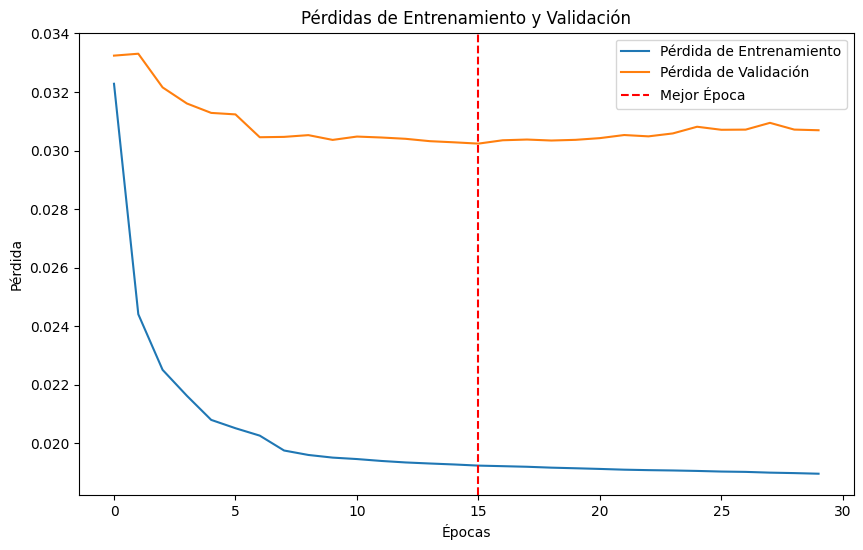

In [23]:
# Hiperparámetros
epochs = 30
learning_rate = 0.001


# Entrenar el modelo
# Entrenar el modelo
results = train_gru_model(
    model, train_loader, val_loader, epochs=epochs, learning_rate=learning_rate, device=device
)

# Extraer los datos del entrenamiento
train_losses = results["train_losses"]
val_losses = results["val_losses"]
best_epoch = results["best_epoch"]
nodel = results["best_model"]

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Pérdida de Entrenamiento")
plt.plot(val_losses, label="Pérdida de Validación")
plt.axvline(best_epoch - 1, color="red", linestyle="--", label="Mejor Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdidas de Entrenamiento y Validación")
plt.legend()
plt.show()

In [24]:
# Evaluar en validación
val_metrics = evaluate_model(
    model, val_loader, scaler, [0, 1], device, dataset_name="Validación"
)

# Evaluar en prueba
test_metrics = evaluate_model(
    model, test_loader, scaler, [0, 1], device, dataset_name="Prueba"
)

Resultados en Validación:
  - MAE: 23.9581
  - RMSE: 34.6899
  - Loss: 0.0302
Resultados en Prueba:
  - MAE: 23.5286
  - RMSE: 34.1299
  - Loss: 0.0293


In [25]:
save_path = "./models/gru_model_x_y_t_day_of_week.pth"

In [28]:
torch.save(model.state_dict(),save_path)

In [29]:
model.load_state_dict(torch.load(save_path))

<ipython-input-29-ed547ae5db2b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


<All keys matched successfully>

In [30]:
# Instancias de métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    DTWMetric(),
    GeoBLEUMetric(),
]

# Evaluar las métricas a partir del día 60
generated_sequences, reference_sequences = evaluate_metrics_sequence(
    test_data,
    model,
    scaler,
    columns=COLUMNS,
    device=device,
)

# Calcular métricas
results = {}
for metric in metrics_instances:
    metric_name = type(metric).__name__
    results[metric_name] = metric.calculate([generated_sequences], [reference_sequences])

# Mostrar resultados
print(f"Métricas para {type(model).__name__} con {COLUMNS} :")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")

Métricas para GRU_Model con ['x', 'y', 't', 'day_of_week'] :
LPPMetric score: 1.2345679012345678
MAEMetric score: 35.44112188612421
DTWMetric score: 332.1240944421785
GeoBLEUMetric score: 0.0006303671366193958


In [31]:
del generated_sequences , reference_sequences
del train_data, val_data, test_data  # Liberar memoria
del train_sequences, val_sequences, test_sequences  # Liberar memoria
del train_dataset, val_dataset, test_dataset  # Liberar memoria
del train_loader, val_loader, test_loader  # Liberar memoria

In [32]:
def fill_missing_data_with_features(
    df: pd.DataFrame, additional_features: list = None
) -> pd.DataFrame:
    """
    Rellena los datos faltantes de usuario, día y timeslot, y maneja características adicionales.
    Asigna -1 a los valores faltantes en las coordenadas (x, y) y en cualquier característica adicional.

    Args:
        df (pd.DataFrame): DataFrame original con columnas ['uid', 'd', 't', 'x', 'y'] y posibles características adicionales.
        additional_features (list): Lista de características adicionales a incluir en el DataFrame.

    Returns:
        pd.DataFrame: DataFrame con datos completos (incluidos los faltantes).
    """
    if additional_features is None:
        additional_features = []

    # Determinar los rangos de uid, días y timeslots
    uids = df["uid"].unique()
    days = np.arange(df["d"].min(), df["d"].max() + 1)
    timeslots = np.arange(48)  # 48 time slots por día

    # Crear una base completa con todas las combinaciones de uid, día y timeslot
    complete_index = pd.MultiIndex.from_product(
        [uids, days, timeslots], names=["uid", "d", "t"]
    )
    complete_df = pd.DataFrame(index=complete_index).reset_index()

    # Combinar con los datos originales
    df = pd.merge(complete_df, df, on=["uid", "d", "t"], how="left")

    # Rellenar valores faltantes para las coordenadas
    df["x"] = df["x"].fillna(-1)
    df["y"] = df["y"].fillna(-1)

    # Rellenar valores faltantes para las características adicionales
    for feature in additional_features:
        if feature not in df.columns:
            # Si la característica no existe en el DataFrame, agregarla con -1
            df[feature] = -1
        else:
            # Rellenar valores faltantes con -1
            df[feature] = df[feature].fillna(-1)

    return df

In [33]:
def add_delta_t(df: pd.DataFrame) -> pd.Series:
    """
    Calcula el delta de timeslots entre observaciones consecutivas considerando días diferentes.

    Args:
        df (pd.DataFrame): DataFrame con columnas `d` (día) y `t` (timeslot dentro del día).

    Returns:
        pd.Series: Serie con los valores de delta_t (cantidad de timeslots sin ping entre observaciones).
    """
    deltas = []
    for i in range(len(df)):
        if i == 0:  # Primer registro no tiene delta
            deltas.append(0)
        else:
            # Calcular el delta considerando días
            current_day, current_t = df.iloc[i]["d"], df.iloc[i]["t"]
            prev_day, prev_t = df.iloc[i - 1]["d"], df.iloc[i - 1]["t"]

            if current_day == prev_day:
                # Mismo día: diferencia simple de timeslots
                delta = current_t - prev_t
            else:
                # Días diferentes: incluir los slots del día anterior y el siguiente
                slots_from_prev_day = 48 - prev_t
                slots_from_current_day = current_t
                delta = (
                    slots_from_prev_day
                    + slots_from_current_day
                    + (current_day - prev_day - 1) * 48
                )

            deltas.append(delta)

    return pd.Series(deltas)


df_delta = add_feature(df, "delta_t", add_delta_t)

fill_data = fill_missing_data_with_features(df_delta, ["delta_t"])

COLUMNS = ["x", "y", "delta_t"]

# Dividir los datos
train_data, val_data, test_data = split_data(fill_data)

# Ajustar el scaler a los datos de entrenamiento
scaler = get_scaler(train_data, COLUMNS)

# Normalizar los datos solamnete con l scaler del train
train_data = normalize_dataset(train_data, scaler, COLUMNS)
val_data = normalize_dataset(val_data, scaler, COLUMNS)
test_data = normalize_dataset(test_data, scaler, COLUMNS)

# Crear las secuencias para cada conjunto
train_sequences = create_sequences(train_data, COLUMNS)
val_sequences = create_sequences(val_data, COLUMNS)
test_sequences = create_sequences(test_data, COLUMNS)

# Crear datasets
train_dataset = GRU_Dataset(train_sequences)
val_dataset = GRU_Dataset(val_sequences)
test_dataset = GRU_Dataset(test_sequences)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
# Hiperparámetros
input_size = 3  # Número de características de entrada: x, y, t
hidden_size = 128  # Tamaño del estado oculto de la GRU
output_size = 2  # Predicción de x, y
num_layers = 3  # Capas GRU
dropout = 0.2  # Dropout para regularización


model = GRU_Model(input_size, hidden_size, output_size, num_layers, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/30, Train Loss: 0.0284, Val Loss: 0.0338
Epoch 2/30, Train Loss: 0.0229, Val Loss: 0.0330
Epoch 3/30, Train Loss: 0.0221, Val Loss: 0.0321
Epoch 4/30, Train Loss: 0.0212, Val Loss: 0.0308
Epoch 5/30, Train Loss: 0.0203, Val Loss: 0.0306
Epoch 6/30, Train Loss: 0.0200, Val Loss: 0.0305
Epoch 7/30, Train Loss: 0.0198, Val Loss: 0.0303
Epoch 8/30, Train Loss: 0.0196, Val Loss: 0.0303
Epoch 9/30, Train Loss: 0.0195, Val Loss: 0.0300
Epoch 10/30, Train Loss: 0.0194, Val Loss: 0.0298
Epoch 11/30, Train Loss: 0.0193, Val Loss: 0.0299
Epoch 12/30, Train Loss: 0.0192, Val Loss: 0.0298
Epoch 13/30, Train Loss: 0.0190, Val Loss: 0.0299
Epoch 14/30, Train Loss: 0.0190, Val Loss: 0.0299
Epoch 15/30, Train Loss: 0.0189, Val Loss: 0.0300
Epoch 16/30, Train Loss: 0.0187, Val Loss: 0.0301
Epoch 17/30, Train Loss: 0.0191, Val Loss: 0.0300
Epoch 18/30, Train Loss: 0.0199, Val Loss: 0.0300
Epoch 19/30, Train Loss: 0.0199, Val Loss: 0.0301
Epoch 20/30, Train Loss: 0.0199, Val Loss: 0.0300
Epoch 21/

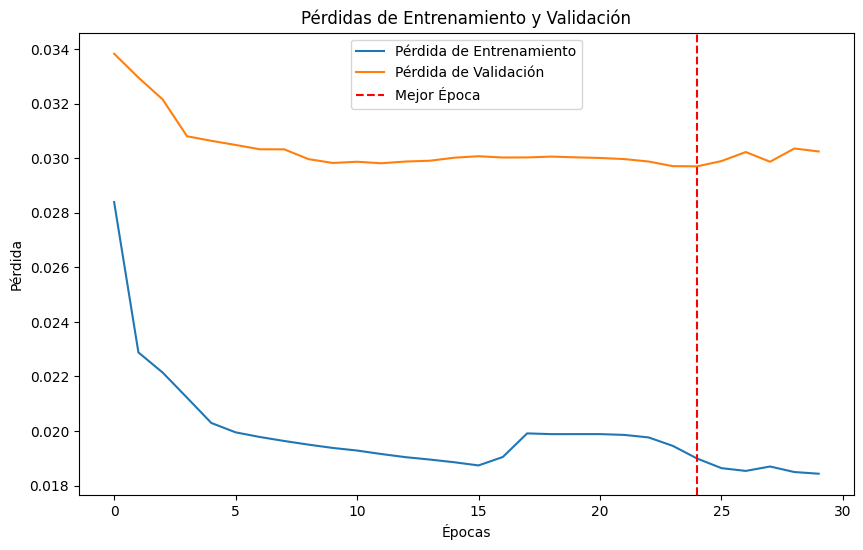

In [35]:
# Hiperparámetros
epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar el modelo
# Entrenar el modelo
results = train_gru_model(
    model, train_loader, val_loader, epochs=epochs, learning_rate=0.001, device=device
)

# Extraer los datos del entrenamiento
train_losses = results["train_losses"]
val_losses = results["val_losses"]
best_epoch = results["best_epoch"]
model = results["best_model"]

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Pérdida de Entrenamiento")
plt.plot(val_losses, label="Pérdida de Validación")
plt.axvline(best_epoch - 1, color="red", linestyle="--", label="Mejor Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdidas de Entrenamiento y Validación")
plt.legend()
plt.show()

In [36]:
# Evaluar en validación
val_metrics = evaluate_model(
    model, val_loader, scaler, [0, 1], device, dataset_name="Validación"
)

# Evaluar en prueba
test_metrics = evaluate_model(
    model, test_loader, scaler, [0, 1], device, dataset_name="Prueba"
)

Resultados en Validación:
  - MAE: 23.1769
  - RMSE: 34.3430
  - Loss: 0.0297
Resultados en Prueba:
  - MAE: 22.2273
  - RMSE: 33.2438
  - Loss: 0.0277


In [37]:
save_path = "./models/gru_model_x_y_delta_t.pth"

In [38]:
torch.save(model.state_dict(),save_path)

In [39]:
model.load_state_dict(torch.load(save_path))

<ipython-input-39-ed547ae5db2b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


<All keys matched successfully>

In [40]:
# Instancias de métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    DTWMetric(),
    GeoBLEUMetric(),
]

# Evaluar las métricas a partir del día 60
generated_sequences, reference_sequences = evaluate_metrics_sequence(
    test_data,
    model,
    scaler,
    columns=COLUMNS,
    device=device,
)

# Calcular métricas
results = {}
for metric in metrics_instances:
    metric_name = type(metric).__name__
    results[metric_name] = metric.calculate([generated_sequences], [reference_sequences])

# Mostrar resultados
print(f"Métricas para {type(model).__name__} con {COLUMNS} :")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")

Métricas para GRU_Model con ['x', 'y', 'delta_t'] :
LPPMetric score: 0.6172839506172839
MAEMetric score: 32.006208325007094
DTWMetric score: 302.6173198541605
GeoBLEUMetric score: 0.0001953880048236439


In [41]:
def add_delta_t(df: pd.DataFrame) -> pd.Series:
    """
    Calcula el delta de timeslots entre observaciones consecutivas considerando días diferentes.

    Args:
        df (pd.DataFrame): DataFrame con columnas `d` (día) y `t` (timeslot dentro del día).

    Returns:
        pd.Series: Serie con los valores de delta_t (cantidad de timeslots sin ping entre observaciones).
    """
    deltas = []
    for i in range(len(df)):
        if i == 0:  # Primer registro no tiene delta
            deltas.append(0)
        else:
            # Calcular el delta considerando días
            current_day, current_t = df.iloc[i]["d"], df.iloc[i]["t"]
            prev_day, prev_t = df.iloc[i - 1]["d"], df.iloc[i - 1]["t"]

            if current_day == prev_day:
                # Mismo día: diferencia simple de timeslots
                delta = current_t - prev_t
            else:
                # Días diferentes: incluir los slots del día anterior y el siguiente
                slots_from_prev_day = 48 - prev_t
                slots_from_current_day = current_t
                delta = (
                    slots_from_prev_day
                    + slots_from_current_day
                    + (current_day - prev_day - 1) * 48
                )

            deltas.append(delta)

    return pd.Series(deltas)


df_delta = add_feature(df, "delta_t", add_delta_t)

fill_data = fill_missing_data_with_features(df_delta, ["delta_t"])

df_day_of_week_delta_t = add_feature(fill_data, "day_of_week", add_day_of_week)

COLUMNS = ["x", "y", "delta_t", "day_of_week"]

# Dividir los datos
train_data, val_data, test_data = split_data(df_day_of_week_delta_t)

# Ajustar el scaler a los datos de entrenamiento
scaler = get_scaler(train_data, COLUMNS)

# Normalizar los datos solamnete con l scaler del train
train_data = normalize_dataset(train_data, scaler, COLUMNS)
val_data = normalize_dataset(val_data, scaler, COLUMNS)
test_data = normalize_dataset(test_data, scaler, COLUMNS)

# Crear las secuencias para cada conjunto
train_sequences = create_sequences(train_data, COLUMNS)
val_sequences = create_sequences(val_data, COLUMNS)
test_sequences = create_sequences(test_data, COLUMNS)

# Crear datasets
train_dataset = GRU_Dataset(train_sequences)
val_dataset = GRU_Dataset(val_sequences)
test_dataset = GRU_Dataset(test_sequences)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# Hiperparámetros
input_size = 4  # Número de características de entrada: x, y, t
hidden_size = 128  # Tamaño del estado oculto de la GRU
output_size = 2  # Predicción de x, y
num_layers = 3  # Capas GRU
dropout = 0.2  # Dropout para regularización


model = GRU_Model(input_size, hidden_size, output_size, num_layers, dropout)
devivce = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/30, Train Loss: 0.0280, Val Loss: 0.0345
Epoch 2/30, Train Loss: 0.0226, Val Loss: 0.0331
Epoch 3/30, Train Loss: 0.0219, Val Loss: 0.0326
Epoch 4/30, Train Loss: 0.0209, Val Loss: 0.0310
Epoch 5/30, Train Loss: 0.0200, Val Loss: 0.0309
Epoch 6/30, Train Loss: 0.0197, Val Loss: 0.0309
Epoch 7/30, Train Loss: 0.0195, Val Loss: 0.0304
Epoch 8/30, Train Loss: 0.0194, Val Loss: 0.0305
Epoch 9/30, Train Loss: 0.0193, Val Loss: 0.0306
Epoch 10/30, Train Loss: 0.0192, Val Loss: 0.0306
Epoch 11/30, Train Loss: 0.0191, Val Loss: 0.0305
Epoch 12/30, Train Loss: 0.0189, Val Loss: 0.0303
Epoch 13/30, Train Loss: 0.0189, Val Loss: 0.0308
Epoch 14/30, Train Loss: 0.0188, Val Loss: 0.0308
Epoch 15/30, Train Loss: 0.0187, Val Loss: 0.0312
Epoch 16/30, Train Loss: 0.0187, Val Loss: 0.0311
Epoch 17/30, Train Loss: 0.0185, Val Loss: 0.0317
Epoch 18/30, Train Loss: 0.0184, Val Loss: 0.0311
Epoch 19/30, Train Loss: 0.0184, Val Loss: 0.0316
Epoch 20/30, Train Loss: 0.0183, Val Loss: 0.0311
Epoch 21/

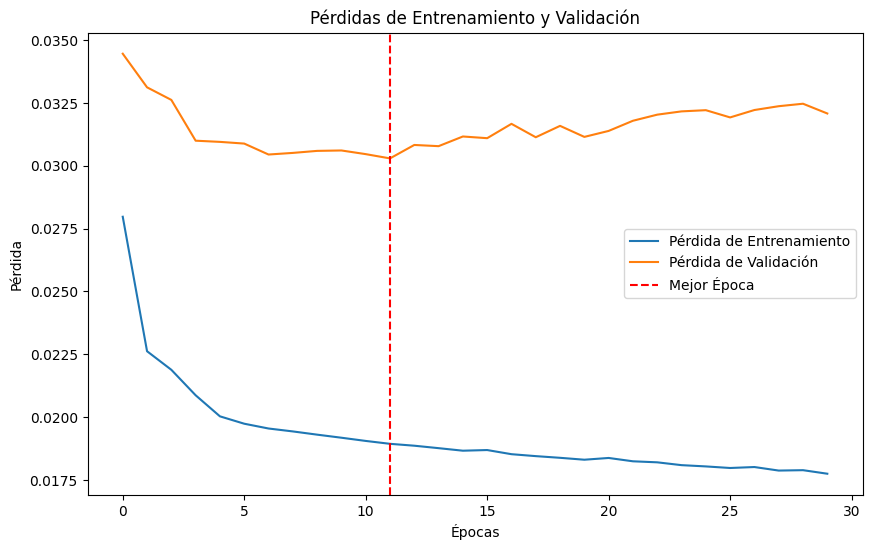

In [43]:
# Hiperparámetros
epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar el modelo
# Entrenar el modelo
results = train_gru_model(
    model, train_loader, val_loader, epochs=epochs, learning_rate=0.001, device=device
)

# Extraer los datos del entrenamiento
train_losses = results["train_losses"]
val_losses = results["val_losses"]
best_epoch = results["best_epoch"]
model = results["best_model"]

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Pérdida de Entrenamiento")
plt.plot(val_losses, label="Pérdida de Validación")
plt.axvline(best_epoch - 1, color="red", linestyle="--", label="Mejor Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdidas de Entrenamiento y Validación")
plt.legend()
plt.show()

In [44]:
# Evaluar en validación
val_metrics = evaluate_model(
    model, val_loader, scaler, [0, 1], device, dataset_name="Validación"
)

# Evaluar en prueba
test_metrics = evaluate_model(
    model, test_loader, scaler, [0, 1], device, dataset_name="Prueba"
)

Resultados en Validación:
  - MAE: 24.2054
  - RMSE: 34.7005
  - Loss: 0.0303
Resultados en Prueba:
  - MAE: 23.8072
  - RMSE: 34.1133
  - Loss: 0.0292


In [45]:
save_path = "./models/gru_model_x_y_delta_t.pth_day_of_week"

In [46]:
torch.save(model.state_dict(),save_path)

In [ ]:
model.load_state_dict(torch.load(save_path))

In [47]:
# Instancias de métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    DTWMetric(),
    GeoBLEUMetric(),
]

# Evaluar las métricas a partir del día 60
generated_sequences, reference_sequences = evaluate_metrics_sequence(
    test_data,
    model,
    scaler,
    columns=COLUMNS,
    device=device,
)

# Calcular métricas
results = {}
for metric in metrics_instances:
    metric_name = type(metric).__name__
    results[metric_name] = metric.calculate([generated_sequences], [reference_sequences])

# Mostrar resultados
print(f"Métricas para {type(model).__name__} con {COLUMNS} :")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")

Métricas para GRU_Model con ['x', 'y', 'delta_t', 'day_of_week'] :
LPPMetric score: 0.6172839506172839
MAEMetric score: 32.9777042272374
DTWMetric score: 314.22382320936987
GeoBLEUMetric score: 0.0014311750447431125
